In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Cell 2 — set working dir to your Drive project folder
import os
DRIVE_DIR = "/content/drive/MyDrive/Colab Notebooks/LmFromScratch"
os.makedirs(DRIVE_DIR, exist_ok=True)   # create if missing
%cd "$DRIVE_DIR"
!ls -la


/content/drive/MyDrive/Colab Notebooks/LmFromScratch
total 106883
-rw------- 1 root root 35635899 Nov 13 19:23 best_model.pth
-rw------- 1 root root      167 Nov 13 13:22 diagnostics.json
drwx------ 2 root root     4096 Nov 13 20:59 experiments
-rw------- 1 root root     1447 Nov 13 19:35 losses.pth
-rw------- 1 root root     1364 Nov 14 11:20 model.py
-rw------- 1 root root    16484 Nov 14 11:32 overfitting.ipynb
-rw------- 1 root root   711343 Nov 10 17:06 Pride_and_Prejudice-Jane_Austen.txt
drwx------ 2 root root     4096 Nov 13 13:33 __pycache__
-rw------- 1 root root    39474 Nov 14 11:32 RegularizedFit.ipynb
-rw------- 1 root root  7268877 Nov 13 13:22 test.pt
-rw------- 1 root root 58235797 Nov 13 13:22 train.pt
-rw------- 1 root root     8577 Nov 14 11:20 train.py
-rw------- 1 root root  7267973 Nov 13 13:22 val.pt
-rw------- 1 root root   248610 Nov 13 13:22 vocab.json


In [9]:
%%bash
cat > model.py <<'PY'
import torch, torch.nn as nn

class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=2, dropout=0.3):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.hidden_size = hidden_size; self.num_layers = num_layers

    def forward(self, x, hidden=None):
        emb = self.embed(x)
        if hidden is None:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
            hidden = (h0, c0)
        out, hidden = self.lstm(emb, hidden)
        out = self.dropout(out)
        logits = self.fc(out)
        return logits, hidden
PY


In [10]:
%%bash
cat > train.py <<'PY'
import os, json, math, argparse, random
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from model import LSTMLanguageModel

# CLI-friendly defaults; override with --drive_dir
parser = argparse.ArgumentParser()
parser.add_argument("--drive_dir", type=str, default="/content/drive/MyDrive/Colab Notebooks/LmFromScratch")
parser.add_argument("--epochs", type=int, default=10)
parser.add_argument("--batch_size", type=int, default=32)
parser.add_argument("--lr", type=float, default=1e-3)
parser.add_argument("--clip", type=float, default=1.0)
parser.add_argument("--seed", type=int, default=42)
args = parser.parse_args()

DRIVE_DIR = args.drive_dir
SEQ_LEN = 30
BATCH_SIZE = args.batch_size
EPOCHS = args.epochs
LR = args.lr
CLIP = args.clip
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(args.seed)
random.seed(args.seed)

def load_data(drive_dir):
    train = torch.load(os.path.join(drive_dir, "train.pt"))
    val   = torch.load(os.path.join(drive_dir, "val.pt"))
    test  = torch.load(os.path.join(drive_dir, "test.pt"))
    with open(os.path.join(drive_dir, "vocab.json"), "r", encoding="utf-8") as f:
        vocab = json.load(f)
    vocab_size = len(vocab["word2id"])
    train_loader = DataLoader(TensorDataset(train["x"], train["y"]), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    val_loader = DataLoader(TensorDataset(val["x"], val["y"]), batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
    test_loader = DataLoader(TensorDataset(test["x"], test["y"]), batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
    return train_loader, val_loader, test_loader, vocab_size

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total, count = 0.0, 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits, _ = model(x)
        loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))
        total += loss.item() * x.size(0)
        count += x.size(0)
    avg = total / count
    return avg, math.exp(avg)

def train(drive_dir):
    train_loader, val_loader, test_loader, vocab_size = load_data(drive_dir)
    model = LSTMLanguageModel(vocab_size=vocab_size, embed_size=256, hidden_size=512, num_layers=2, dropout=0.3).to(DEVICE)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    opt = optim.Adam(model.parameters(), lr=LR)
    best_val = float("inf"); train_losses, val_losses = [], []
    os.makedirs(drive_dir, exist_ok=True)
    for epoch in range(1, EPOCHS+1):
        model.train(); total_train=0.0
        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            opt.zero_grad()
            logits, _ = model(x)
            loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
            opt.step()
            total_train += loss.item() * x.size(0)
        avg_train = total_train / len(train_loader.dataset)
        val_loss, val_ppl = evaluate(model, val_loader, criterion)
        train_losses.append(avg_train); val_losses.append(val_loss)
        print(f"Epoch {epoch}/{EPOCHS} | Train loss: {avg_train:.4f} | Val loss: {val_loss:.4f} | Val ppl: {val_ppl:.2f}")
        if val_loss < best_val:
            best_val = val_loss
            torch.save(model.state_dict(), os.path.join(drive_dir, "best_model.pth"))
            print(" Saved best_model.pth")
    model.load_state_dict(torch.load(os.path.join(drive_dir, "best_model.pth")))
    test_loss, test_ppl = evaluate(model, test_loader, criterion)
    print(f"Test loss: {test_loss:.4f} | Test perplexity: {test_ppl:.2f}")
    torch.save({"train_losses": train_losses, "val_losses": val_losses}, os.path.join(drive_dir, "losses.pth"))

if __name__ == "__main__":
    train(DRIVE_DIR)
PY


In [11]:
#
!python train.py --epochs 10 --batch_size 32


Epoch 1/10 | Train loss: 3.8258 | Val loss: 5.2182 | Val ppl: 184.60
 Saved best_model.pth
Epoch 2/10 | Train loss: 1.9370 | Val loss: 6.5579 | Val ppl: 704.77
Epoch 3/10 | Train loss: 1.2314 | Val loss: 7.6269 | Val ppl: 2052.68
Epoch 4/10 | Train loss: 0.9365 | Val loss: 8.3448 | Val ppl: 4208.16
Epoch 5/10 | Train loss: 0.7943 | Val loss: 8.8818 | Val ppl: 7199.43
Epoch 6/10 | Train loss: 0.7126 | Val loss: 9.2435 | Val ppl: 10337.21
Epoch 7/10 | Train loss: 0.6605 | Val loss: 9.5397 | Val ppl: 13900.44
Epoch 8/10 | Train loss: 0.6241 | Val loss: 9.8101 | Val ppl: 18217.61
Epoch 9/10 | Train loss: 0.5966 | Val loss: 10.1207 | Val ppl: 24852.18
Epoch 10/10 | Train loss: 0.5756 | Val loss: 10.1933 | Val ppl: 26724.42
Test loss: 6.6605 | Test perplexity: 780.93


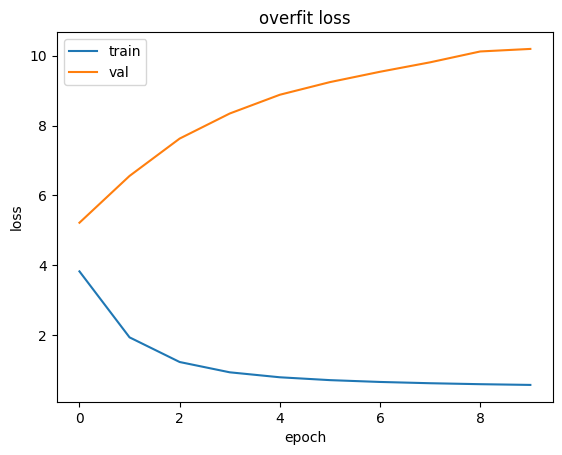

In [5]:
import torch, matplotlib.pyplot as plt, os
d = torch.load(os.path.join(DRIVE_DIR, "losses.pth"))
plt.plot(d["train_losses"], label="train")
plt.plot(d["val_losses"], label="val")
plt.title("overfit loss"); plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.show()